In [1]:
%reload_ext autoreload
%autoreload 2
from backend import load_data, data_wrangling, calculate_completion_rate, error_rate, drop_off_rate, statistic_func, calculate_avg_time_per_step
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency


In [2]:
client_profiles, experiment_roster, web_group = load_data()

In [3]:
client_process_counts, final_rooster_process_counts_profile, control_profile_df, test_profile_df, web_group_experiment, client_profile_experiment = data_wrangling(web_group,experiment_roster,client_profiles)

In [4]:
experiment_roster.dropna(inplace=True)

In [5]:
experiment_roster

client_id Variation
0        9988021      Test
1        8320017      Test
2        4033851   Control
3        1982004      Test
4        9294070   Control
...          ...       ...
50495     393005   Control
50496    2908510   Control
50497    7230446      Test
50498    5230357      Test
50499    6334360      Test

[50500 rows x 2 columns]

# Not all clients were part of experiment

Concatenating both web data files.

In [6]:
web_group = pd.concat([df_web_data_pt1,df_web_data_pt2])

NameError: name 'df_web_data_pt1' is not defined

Transforming process_step values into numerical values to better manipulate the data.

In [7]:
process_dict = {'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4}
web_group['process_step'] = web_group['process_step'].replace(process_dict)

In [8]:
web_group

client_id             visitor_id                      visit_id  \
0         9988021   580560515_7732621733  781255054_21935453173_531117   
1         9988021   580560515_7732621733  781255054_21935453173_531117   
2         9988021   580560515_7732621733  781255054_21935453173_531117   
3         9988021   580560515_7732621733  781255054_21935453173_531117   
4         9988021   580560515_7732621733  781255054_21935453173_531117   
...           ...                    ...                           ...   
412259    9668240   388766751_9038881013   922267647_3096648104_968866   
412260    9668240   388766751_9038881013   922267647_3096648104_968866   
412261    9668240   388766751_9038881013   922267647_3096648104_968866   
412262    9668240   388766751_9038881013   922267647_3096648104_968866   
412263     674799  947159805_81558194550   86152093_47511127657_716022   

        process_step           date_time  
0                  3 2017-04-17 15:27:07  
1                  2 2017-04-17 15:26:51  
2                  3 2017-04-17 15:19:22  
3                  2 2017-04-17 15:19:13  
4                  3 2017-04-17 15:18:04  
...              ...                 ...  
412259             0 2017-05-24 18:46:10  
412260             0 2017-05-24 18:45:29  
412261             1 2017-05-24 18:44:51  
412262             0 2017-05-24 18:44:34  
412263             0 2017-06-03 12:17:09  

[755405 rows x 5 columns]

In [9]:
web_group['visit_id'].nunique()

158095

In [96]:
web_group['visitor_id'].nunique()

130236

In [97]:
web_group['client_id'].nunique()

120157

In [98]:
web_group['process_step'].nunique()

5

In [99]:
web_group['date_time'].nunique()

629363

Creating a count of how many times the client was on a specific step.

In [100]:
client_process_counts = web_group.groupby('client_id')['process_step'].value_counts().unstack(fill_value=0)

In [103]:
client_process_counts

process_step  0  1  2  3  4
client_id                  
169           1  1  1  1  1
336           2  0  0  0  0
546           1  1  1  1  1
555           1  1  1  1  1
647           1  1  1  1  1
...          .. .. .. .. ..
9999729       4  3  2  1  1
9999768       3  3  3  2  1
9999832       1  1  0  0  0
9999839       2  1  1  1  1
9999875       1  2  1  1  1

[120157 rows x 5 columns]

In [106]:
# Renaming columns.
column_rename = {0: 'start', 1: 'step_1', 2: 'step_2', 3: 'step_3', 4: 'confirm'}
client_process_counts = client_process_counts.rename(columns=column_rename)

In [107]:
client_process_counts

process_step  start  step_1  step_2  step_3  confirm
client_id                                           
169               1       1       1       1        1
336               2       0       0       0        0
546               1       1       1       1        1
555               1       1       1       1        1
647               1       1       1       1        1
...             ...     ...     ...     ...      ...
9999729           4       3       2       1        1
9999768           3       3       3       2        1
9999832           1       1       0       0        0
9999839           2       1       1       1        1
9999875           1       2       1       1        1

[120157 rows x 5 columns]

Merging process_counts with experiment roster to filter out the clients that weren't part of the experiment.

In [108]:
final_rooster_process_counts = pd.merge(client_process_counts, experiment_roster, on='client_id', how='inner')

Adding client information to last dataframe(final_rooster_process_counts).

In [109]:
final_rooster_process_counts_profile = pd.merge(final_rooster_process_counts, client_profiles, on='client_id', how='inner')

In [110]:
final_rooster_process_counts_profile

client_id  start  step_1  step_2  step_3  confirm Variation  \
0            555      1       1       1       1        1      Test   
1            647      1       1       1       1        1      Test   
2            934      4       0       0       0        0      Test   
3           1028      1       5       2       1        0   Control   
4           1104      2       0       0       0        0   Control   
...          ...    ...     ...     ...     ...      ...       ...   
50495    9999150      2       1       0       0        0      Test   
50496    9999400      1       1       1       1        1      Test   
50497    9999626      1       1       0       0        0      Test   
50498    9999729      4       3       2       1        1      Test   
50499    9999832      1       1       0       0        0      Test   

       clnt_tenure_yr  clnt_tenure_mnth  clnt_age gendr  num_accts        bal  \
0                 3.0              46.0      29.5     U        2.0   25454.66   
1                12.0             151.0      57.5     M        2.0   30525.80   
2                 9.0             109.0      51.0     F        2.0   32522.88   
3                12.0             145.0      36.0     M        3.0  103520.22   
4                 5.0              66.0      48.0     U        3.0  154643.94   
...               ...               ...       ...   ...        ...        ...   
50495             5.0              66.0      30.0     U        3.0   97141.71   
50496             7.0              86.0      28.5     U        2.0   51787.04   
50497             9.0             113.0      35.0     M        2.0   36642.88   
50498            10.0             124.0      31.0     F        3.0  107059.74   
50499            23.0             281.0      49.0     F        2.0  431887.61   

       calls_6_mnth  logons_6_mnth  
0               2.0            6.0  
1               0.0            4.0  
2               0.0            3.0  
3               1.0            4.0  
4               6.0            9.0  
...             ...            ...  
50495           6.0            9.0  
50496           0.0            3.0  
50497           6.0            9.0  
50498           6.0            9.0  
50499           1.0            4.0  

[50500 rows x 15 columns]

Extracting clients from each group.

In [111]:
control_df = final_rooster_process_counts[final_rooster_process_counts['Variation'] == 'Control']
test_df = final_rooster_process_counts[final_rooster_process_counts['Variation'] == 'Test']

In [112]:
control_df

client_id  start  step_1  step_2  step_3  confirm Variation
3           1028      1       5       2       1        0   Control
4           1104      2       0       0       0        0   Control
5           1186      2       1       1       0        0   Control
6           1195      1       1       1       1        1   Control
7           1197      1       1       2       2        1   Control
...          ...    ...     ...     ...     ...      ...       ...
50485    9997125      1       1       1       1        1   Control
50486    9997391      1       1       3       3        0   Control
50487    9997470      8       4       2       2        1   Control
50489    9998346      1       2       4       4        1   Control
50492    9998921      1       0       0       0        0   Control

[23532 rows x 7 columns]

In [113]:
test_df

client_id  start  step_1  step_2  step_3  confirm Variation
0            555      1       1       1       1        1      Test
1            647      1       1       1       1        1      Test
2            934      4       0       0       0        0      Test
8           1336      1       1       1       1        3      Test
9           1346      5       2       1       2        0      Test
...          ...    ...     ...     ...     ...      ...       ...
50495    9999150      2       1       0       0        0      Test
50496    9999400      1       1       1       1        1      Test
50497    9999626      1       1       0       0        0      Test
50498    9999729      4       3       2       1        1      Test
50499    9999832      1       1       0       0        0      Test

[26968 rows x 7 columns]

Verifying how many clients reached the last step in both groups.

In [114]:
(test_df['confirm'] > 0).value_counts()

confirm
True     18687
False     8281
Name: count, dtype: int64

In [115]:
(control_df['confirm'] > 0).value_counts()

confirm
True     15434
False     8098
Name: count, dtype: int64

Merging web data with experiment roster to classify clients by their group.

In [116]:
web_group_experiment = pd.merge(web_group, experiment_roster, on='client_id', how='inner')

In [117]:
web_group_experiment

client_id             visitor_id                      visit_id  \
0         9988021   580560515_7732621733  781255054_21935453173_531117   
1         9988021   580560515_7732621733  781255054_21935453173_531117   
2         9988021   580560515_7732621733  781255054_21935453173_531117   
3         9988021   580560515_7732621733  781255054_21935453173_531117   
4         9988021   580560515_7732621733  781255054_21935453173_531117   
...           ...                    ...                           ...   
321304    1574008  117364417_77840596075  528720790_71583064618_169151   
321305    2908510  814969699_90652851448   562606085_36368381773_92090   
321306    2908510  814969699_90652851448   562606085_36368381773_92090   
321307    2908510  814969699_90652851448   562606085_36368381773_92090   
321308    2908510  814969699_90652851448   562606085_36368381773_92090   

        process_step           date_time Variation  
0                  3 2017-04-17 15:27:07      Test  
1                  2 2017-04-17 15:26:51      Test  
2                  3 2017-04-17 15:19:22      Test  
3                  2 2017-04-17 15:19:13      Test  
4                  3 2017-04-17 15:18:04      Test  
...              ...                 ...       ...  
321304             0 2017-05-06 23:43:27      Test  
321305             0 2017-05-10 22:57:17   Control  
321306             2 2017-05-10 22:56:31   Control  
321307             1 2017-05-10 22:56:23   Control  
321308             0 2017-05-10 22:56:20   Control  

[321309 rows x 6 columns]

Merging last dataset (web_group_experiment) with client profiles.

In [118]:
client_profile_experiment = pd.merge(web_group_experiment, client_profiles, on='client_id', how='left')
client_profile_experiment

client_id             visitor_id                      visit_id  \
0         9988021   580560515_7732621733  781255054_21935453173_531117   
1         9988021   580560515_7732621733  781255054_21935453173_531117   
2         9988021   580560515_7732621733  781255054_21935453173_531117   
3         9988021   580560515_7732621733  781255054_21935453173_531117   
4         9988021   580560515_7732621733  781255054_21935453173_531117   
...           ...                    ...                           ...   
321304    1574008  117364417_77840596075  528720790_71583064618_169151   
321305    2908510  814969699_90652851448   562606085_36368381773_92090   
321306    2908510  814969699_90652851448   562606085_36368381773_92090   
321307    2908510  814969699_90652851448   562606085_36368381773_92090   
321308    2908510  814969699_90652851448   562606085_36368381773_92090   

        process_step           date_time Variation  clnt_tenure_yr  \
0                  3 2017-04-17 15:27:07      Test             5.0   
1                  2 2017-04-17 15:26:51      Test             5.0   
2                  3 2017-04-17 15:19:22      Test             5.0   
3                  2 2017-04-17 15:19:13      Test             5.0   
4                  3 2017-04-17 15:18:04      Test             5.0   
...              ...                 ...       ...             ...   
321304             0 2017-05-06 23:43:27      Test            10.0   
321305             0 2017-05-10 22:57:17   Control            21.0   
321306             2 2017-05-10 22:56:31   Control            21.0   
321307             1 2017-05-10 22:56:23   Control            21.0   
321308             0 2017-05-10 22:56:20   Control            21.0   

        clnt_tenure_mnth  clnt_age gendr  num_accts        bal  calls_6_mnth  \
0                   64.0      79.0     U        2.0  189023.86           1.0   
1                   64.0      79.0     U        2.0  189023.86           1.0   
2                   64.0      79.0     U        2.0  189023.86           1.0   
3                   64.0      79.0     U        2.0  189023.86           1.0   
4                   64.0      79.0     U        2.0  189023.86           1.0   
...                  ...       ...   ...        ...        ...           ...   
321304             121.0      55.0     U        2.0  153238.83           3.0   
321305             252.0      34.0     M        3.0  141808.05           6.0   
321306             252.0      34.0     M        3.0  141808.05           6.0   
321307             252.0      34.0     M        3.0  141808.05           6.0   
321308             252.0      34.0     M        3.0  141808.05           6.0   

        logons_6_mnth  
0                 4.0  
1                 4.0  
2                 4.0  
3                 4.0  
4                 4.0  
...               ...  
321304            6.0  
321305            9.0  
321306            9.0  
321307            9.0  
321308            9.0  

[321309 rows x 14 columns]

Sorting by client_id and datetime to start calculating completion rate, average time per step and drop off rate.

In [119]:
sorted_df = web_group_experiment.sort_values(by=['client_id', 'date_time'])
result = sorted_df.groupby('client_id')['date_time'].diff()

In [120]:
sorted_df.query('client_id == 647')

client_id            visitor_id                     visit_id  \
147820        647  66758770_53988066587  40369564_40101682850_311847   
147819        647  66758770_53988066587  40369564_40101682850_311847   
147818        647  66758770_53988066587  40369564_40101682850_311847   
147817        647  66758770_53988066587  40369564_40101682850_311847   
147816        647  66758770_53988066587  40369564_40101682850_311847   

        process_step           date_time Variation  
147820             0 2017-04-12 15:41:28      Test  
147819             1 2017-04-12 15:41:35      Test  
147818             2 2017-04-12 15:41:53      Test  
147817             3 2017-04-12 15:45:02      Test  
147816             4 2017-04-12 15:47:45      Test

Building completion rate function

For further information about the function, please refer to backend.py

In [123]:
def calculate_completion_rate(data,variation=None):

    if (variation == 'Test') or (variation == 'Control'):
        variation_df = data[data['Variation']== variation]
        confirm_step_users = variation_df[variation_df['process_step'] == 4]['client_id'].nunique()
        total_users = variation_df['client_id'].nunique()
        
    else:
        confirm_step_users = data[data['process_step'] == 4]['client_id'].nunique()
        total_users = data['client_id'].nunique()

    completion_rate_percentage = (confirm_step_users / total_users) * 100

    return completion_rate_percentage

In [124]:
calculate_completion_rate(web_group_experiment,'Control')

65.58728539860616

In [125]:
calculate_completion_rate(web_group_experiment,'Test')

69.29323642835953

Building completion rate function

For further information about the function, please refer to backend.py

In [126]:
def calculate_avg_time_per_step(data,variation=None):
    
    if (variation == 'Test') or (variation == 'Control'):
        
        variation_df = data[data['Variation']== variation]
        variation_df['time_spent_on_step'] = variation_df.groupby('client_id')['date_time'].diff()
        avg_time_per_step = variation_df.groupby('process_step')['time_spent_on_step'].mean()
        avg_time_per_step = avg_time_per_step.reindex(index = ['start', 'step_1', 'step_2', 'step_3', 'confirm'])
    else:
        
        data['time_spent_on_step'] = data.groupby('client_id')['date_time'].diff()
        avg_time_per_step = data.groupby('process_step')['time_spent_on_step'].mean()
        avg_time_per_step = avg_time_per_step.reindex(index = ['start', 'step_1', 'step_2', 'step_3', 'confirm'])
        
    return avg_time_per_step

Experimenting with time to reach desired results.

In [131]:
#sorted_df = web_group_experiment.sort_values(by=['client_id', 'date_time'])

control_time_spent = sorted_df[sorted_df['Variation']=='Control']

control_time_spent['time_spent_on_step'] = control_time_spent.groupby('client_id')['date_time'].diff()

avg_time_per_step_control = control_time_spent.groupby('process_step')['time_spent_on_step'].mean()

index_rename = {0: 'start', 1: 'step_1', 2: 'step_2', 3: 'step_3', 4: 'confirm'}

avg_time_per_step_control = avg_time_per_step_control.rename(index=index_rename)

#avg_time_per_step_control = avg_time_per_step_control.reindex(index = ['start', 'step_1', 'step_2', 'step_3', 'confirm'])

avg_time_per_step_control

/var/folders/l6/ynlhkqws5hv7wtyyn6rr6t4c0000gn/T/ipykernel_807/3099442970.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_time_spent['time_spent_on_step'] = control_time_spent.groupby('client_id')['date_time'].diff()


process_step
start     4 days 05:57:44.544592030
step_1    0 days 00:30:38.781647281
step_2    0 days 00:00:39.342259834
step_3    0 days 00:09:35.220494575
confirm   0 days 18:21:17.307379630
Name: time_spent_on_step, dtype: timedelta64[ns]

In [132]:
test_time_spent = sorted_df[sorted_df['Variation']=='Test']

test_time_spent['time_spent_on_step'] = test_time_spent.groupby('client_id')['date_time'].diff()

avg_time_per_step_test = test_time_spent.groupby('process_step')['time_spent_on_step'].mean()

index_rename = {0: 'start', 1: 'step_1', 2: 'step_2', 3: 'step_3', 4: 'confirm'}

avg_time_per_step_test = avg_time_per_step_test.rename(index=index_rename)

# avg_time_per_step_test = avg_time_per_step_test.reindex(index = ['start', 'step_1', 'step_2', 'step_3', 'confirm'])

avg_time_per_step_test

/var/folders/l6/ynlhkqws5hv7wtyyn6rr6t4c0000gn/T/ipykernel_807/2488044916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_time_spent['time_spent_on_step'] = test_time_spent.groupby('client_id')['date_time'].diff()


process_step
start     3 days 02:55:49.873986735
step_1    0 days 00:22:19.804570955
step_2    0 days 00:01:51.212471355
step_3    0 days 00:12:18.920516488
confirm   1 days 05:00:32.783103231
Name: time_spent_on_step, dtype: timedelta64[ns]

In [135]:
sorted_df['time_spent_on_step'] = sorted_df.groupby('client_id')['date_time'].diff()

avg_time_per_step = sorted_df.groupby('process_step')['time_spent_on_step'].mean()

index_rename = {0: 'start', 1: 'step_1', 2: 'step_2', 3: 'step_3', 4: 'confirm'}

avg_time_per_step = avg_time_per_step.rename(index=index_rename)

#avg_time_per_step = avg_time_per_step.reindex(index = ['start', 'step_1', 'step_2', 'step_3', 'confirm'])

avg_time_per_step

process_step
start     3 days 15:02:39.424504584
step_1    0 days 00:25:56.019441799
step_2    0 days 00:01:18.503631663
step_3    0 days 00:11:02.287741086
confirm   1 days 00:40:39.014174987
Name: time_spent_on_step, dtype: timedelta64[ns]

In [35]:
calculate_avg_time_per_step(web_group_experiment)

process_step
start     0 days 10:34:55.327400221
step_1    0 days 04:44:40.800457751
step_2    0 days 01:26:44.953561331
step_3    0 days 02:33:59.386640609
confirm   7 days 06:23:06.917887202
Name: time_spent_on_step, dtype: timedelta64[ns]

In [36]:
calculate_avg_time_per_step(web_group_experiment,'Test')

/var/folders/l6/ynlhkqws5hv7wtyyn6rr6t4c0000gn/T/ipykernel_807/1006983066.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variation_df['time_spent_on_step'] = variation_df.groupby('client_id')['date_time'].diff()


process_step
start     0 days 09:17:27.053622956
step_1    0 days 02:54:46.601001033
step_2    0 days 01:35:27.801749659
step_3    0 days 02:54:23.903277084
confirm   5 days 23:26:23.550332778
Name: time_spent_on_step, dtype: timedelta64[ns]

In [37]:
calculate_avg_time_per_step(web_group_experiment,'Control')

/var/folders/l6/ynlhkqws5hv7wtyyn6rr6t4c0000gn/T/ipykernel_807/1006983066.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variation_df['time_spent_on_step'] = variation_df.groupby('client_id')['date_time'].diff()


process_step
start     0 days 12:08:42.464061324
step_1    0 days 07:11:47.159839796
step_2    0 days 01:16:10.175066634
step_3    0 days 02:10:09.278050173
confirm   9 days 12:45:21.393020281
Name: time_spent_on_step, dtype: timedelta64[ns]

Previous average time per step functions didn't make sense. Started experimenting.

We found that the mistake was we weren't sorting by client_id and data_time before calculating the difference in time. This resulted in averages of over one day, because clients sometimes started the process, left for the day, and continued on another day. This was throwing off our results.

In [141]:

merged_web_data = web_group_experiment.sort_values(by=['client_id', 'date_time'])

merged_web_data['time_diff'] = merged_web_data.groupby('client_id')['date_time'].diff()

merged_web_data = merged_web_data[merged_web_data['process_step'] != 0]

merged_web_data[['client_id', 'process_step', 'date_time', 'time_diff','Variation']]

client_id  process_step           date_time       time_diff Variation
77130         555             1 2017-04-15 12:58:03 0 days 00:00:07      Test
77129         555             2 2017-04-15 12:58:35 0 days 00:00:32      Test
77128         555             3 2017-04-15 13:00:14 0 days 00:01:39      Test
77127         555             4 2017-04-15 13:00:34 0 days 00:00:20      Test
147819        647             1 2017-04-12 15:41:35 0 days 00:00:07      Test
...           ...           ...                 ...             ...       ...
114790    9999729             1 2017-05-08 16:08:30 0 days 00:00:05      Test
114789    9999729             2 2017-05-08 16:08:40 0 days 00:00:10      Test
114788    9999729             3 2017-05-08 16:09:19 0 days 00:00:39      Test
114787    9999729             4 2017-05-08 16:09:40 0 days 00:00:21      Test
264542    9999832             1 2017-05-16 16:46:11 0 days 00:00:08      Test

[217227 rows x 5 columns]

In [143]:
merged_web_data_test = merged_web_data[merged_web_data['Variation']=='Test']

In [144]:
merged_web_data_control = merged_web_data[merged_web_data['Variation']=='Control']

In [146]:
average_time_per_step_control = merged_web_data_control.groupby('process_step')['time_diff'].mean()

index_rename = {1: 'step_1', 2: 'step_2', 3: 'step_3', 4: 'confirm'}

average_time_per_step_control = average_time_per_step_control.rename(index=index_rename)

average_time_per_step_control

process_step
step_1    0 days 00:30:38.781647281
step_2    0 days 00:00:39.342259834
step_3    0 days 00:09:35.220494575
confirm   0 days 18:21:17.307379630
Name: time_diff, dtype: timedelta64[ns]

In [147]:
average_time_per_step_test = merged_web_data_test.groupby('process_step')['time_diff'].mean()

index_rename = {1: 'step_1', 2: 'step_2', 3: 'step_3', 4: 'confirm'}

average_time_per_step_test = average_time_per_step_test.rename(index=index_rename)

average_time_per_step_test

process_step
step_1    0 days 00:22:19.804570955
step_2    0 days 00:01:51.212471355
step_3    0 days 00:12:18.920516488
confirm   1 days 05:00:32.783103231
Name: time_diff, dtype: timedelta64[ns]

Building error rate function.

For further information about the function, please refer to backend.py

In [127]:
def calculate_error_rate(data,variation=None):

    if (variation == 'Test') or (variation == 'Control'):
        variation_df = data[data['Variation']== variation]
        total_users_at_step = variation_df['client_id'].groupby(variation_df['process_step']).nunique()
        backward_steps = variation_df[variation_df['process_step'].shift(1) > variation_df['process_step']]
        users_proceeding_to_next_step = variation_df.groupby('process_step')['client_id'].nunique().shift(-1)
        users_took_backward_steps = backward_steps.groupby('process_step')['client_id'].nunique()
        
        #Overall Error Rate
        total_users_took_backward_steps = variation_df[variation_df['process_step'].shift(1) > variation_df['process_step']]['client_id'].nunique()
        total_users = variation_df['client_id'].nunique()

    else:
        total_users_at_step = data['client_id'].groupby(data['process_step']).nunique()
        backward_steps = data[data['process_step'].shift(1) > data['process_step']]
        users_proceeding_to_next_step = data.groupby('process_step')['client_id'].nunique().shift(-1)
        users_took_backward_steps = backward_steps.groupby('process_step')['client_id'].nunique()
        
        # Overall Error Rate
        total_users_took_backward_steps = data[data['process_step'].shift(1) > data['process_step']]['client_id'].nunique()
        total_users = data['client_id'].nunique()
        

    error_rate_percentage = (users_took_backward_steps / total_users_at_step) * 100
    error_rate_percentage = error_rate_percentage.reindex(index = ['start', 'step_1', 'step_2', 'step_3', 'confirm'])
    
    overall_error_rate_percentage = (total_users_took_backward_steps / total_users) * 100
    
    return error_rate_percentage, overall_error_rate_percentage

In [128]:
calculate_error_rate(web_group_experiment)

(process_step
 start      88.515457
 step_1     91.933632
 step_2     92.644471
 step_3           NaN
 confirm    96.782040
 Name: client_id, dtype: float64,
 88.77029702970297)

In [129]:
calculate_error_rate(web_group_experiment,'Control')

(process_step
 start      85.908450
 step_1     92.397777
 step_2     92.375335
 step_3           NaN
 confirm    98.121031
 Name: client_id, dtype: float64,
 86.19751827298997)

In [130]:
calculate_error_rate(web_group_experiment,'Test')

(process_step
 start      90.824244
 step_1     91.519347
 step_2     92.852008
 step_3           NaN
 confirm    95.504896
 Name: client_id, dtype: float64,
 91.02640166122812)

Testing to see if error function was functioning properly.

In [54]:
merged_web_data.query("process_step == 'confirm' & error == 1")

client_id             visitor_id                      visit_id  \
77127         555  402506806_56087378777  637149525_38041617439_716659   
147816        647   66758770_53988066587   40369564_40101682850_311847   
14441        1195  766842522_69992551638  393817425_39015278493_996341   
34092        1197  753759429_54481946928   71862471_21202285428_848395   
311783       1336  920624746_32603333901  583743392_96265099036_939815   
...           ...                    ...                           ...   
146060    9998851  660529049_81285947655  310744937_17135608286_213964   
106318    9998964  502193753_63097042630  699981922_52880598802_858635   
42685     9999009  212849256_28644888524  149965839_24823291142_245569   
193892    9999400  915967319_19082377501  288904166_90826265353_276104   
114787    9999729  834634258_21862004160  870243567_56915814033_814203   

       process_step           date_time Variation time_spent_on_step  \
77127       confirm 2017-04-15 13:00:34      Test                NaT   
147816      confirm 2017-04-12 15:47:45      Test                NaT   
14441       confirm 2017-04-05 20:19:31   Control                NaT   
34092       confirm 2017-04-01 17:17:59   Control                NaT   
311783      confirm 2017-05-08 06:08:43      Test  -1 days +21:47:05   
...             ...                 ...       ...                ...   
146060      confirm 2017-04-05 12:08:43      Test                NaT   
106318      confirm 2017-04-05 23:50:02      Test                NaT   
42685       confirm 2017-03-31 07:20:36      Test                NaT   
193892      confirm 2017-04-20 05:23:27      Test                NaT   
114787      confirm 2017-05-08 16:09:40      Test   18 days 01:48:13   

             time_diff  error  
77127  0 days 00:00:20      1  
147816 0 days 00:02:43      1  
14441  0 days 00:01:23      1  
34092  0 days 00:00:17      1  
311783 0 days 00:01:49      1  
...                ...    ...  
146060 0 days 00:00:31      1  
106318 0 days 00:01:14      1  
42685  0 days 00:01:58      1  
193892 0 days 00:00:24      1  
114787 0 days 00:00:21      1  

[34215 rows x 9 columns]

In [166]:

error_test_1 = web_group_experiment.sort_values(by=['client_id', 'date_time'])


error_mask = error_test_1.groupby('client_id')['process_step'].shift(1) > error_test_1['process_step']


total_errors = error_mask.sum()


total_steps = error_test_1.shape[0]


error_rate = total_errors / total_steps *100


average_error_per_step = error_mask.groupby(web_group_experiment['process_step']).mean()*100


print("Total Errors:", total_errors)
print("Total Steps:", total_steps)
print("Error Rate:", error_rate)
average_error_per_step

Total Errors: 32423
Total Steps: 321309
Error Rate: 10.090909373842626


process_step
0    20.933495
1     8.480916
2     8.214505
3     0.326562
4     0.000000
Name: process_step, dtype: float64

Our attempt to calculate the click-through-rate. Due to time limitation, we decided to pursue other parts of the project. Still, it's in our interest to finish the function, since it can be useful in other projects.

In [131]:
def calculate_ctr(data,variation=None):
    
    if (variation == 'Test') or (variation == 'Control'):
        variation_df = data[data['Variation']== variation]
        total_users_at_step = variation_df['client_id'].groupby(variation_df['process_step']).nunique()
        users_proceeding_to_next_step = variation_df.groupby('process_step')['client_id'].nunique().shift(-1)

    else:
        total_users_at_step = data['client_id'].groupby(data['process_step']).nunique()
        users_proceeding_to_next_step = data.groupby('process_step')['client_id'].nunique().shift(-1)
    
    
    users_proceeding_to_next_step = users_proceeding_to_next_step.fillna(0)
    
    ctr = (users_proceeding_to_next_step / total_users_at_step)*100
    ctr = ctr.reindex(index = ['start', 'step_1', 'step_2', 'step_3', 'confirm'])


    return ctr

In [132]:
calculate_ctr(web_group_experiment)

process_step
start       88.703171
step_1      92.095725
step_2      93.632052
step_3       0.000000
confirm    146.760060
Name: client_id, dtype: float64

In [133]:
calculate_ctr(web_group_experiment,'Control')

process_step
start       86.130701
step_1      92.546645
step_2      93.415550
step_3       0.000000
confirm    151.593884
Name: client_id, dtype: float64

In [134]:
calculate_ctr(web_group_experiment,'Test')

process_step
start       90.959181
step_1      91.721268
step_2      93.813460
step_3       0.000000
confirm    142.767699
Name: client_id, dtype: float64

In [168]:

ctr_test_1 = web_group_experiment.sort_values(by=['client_id', 'date_time'])


ctr_mask = (ctr_test_1['process_step'].shift(1) == 'start') & ((ctr_test_1['process_step'] == 'step_1') | (ctr_test_1['process_step'] == 'step_2'))


successful_ctr_events = ctr_mask.sum()


total_possible_ctr_events = (ctr_test_1['process_step'] == 'start').sum()


ctr_rate = successful_ctr_events / total_possible_ctr_events

# Displaying the result
print("Successful CTR Events:", successful_ctr_events)
print("Total Possible CTR Events:", total_possible_ctr_events)
print("Click-Through-Rate:", ctr_rate)

Successful CTR Events: 0
Total Possible CTR Events: 0
Click-Through-Rate: nan


/var/folders/l6/ynlhkqws5hv7wtyyn6rr6t4c0000gn/T/ipykernel_807/3104391829.py:15: RuntimeWarning: invalid value encountered in scalar divide
  ctr_rate = successful_ctr_events / total_possible_ctr_events


In [237]:

ctr_test_2 = web_group_experiment.sort_values(by=['client_id', 'date_time'])


ctr_mask_2 = ctr_test_2.groupby('client_id')['process_step'].shift(-1) == ctr_test_2['process_step'].shift(-1)


click_through_rate_per_step = ctr_mask_2.groupby(merged_web_data['process_step']).mean()

print(click_through_rate_per_step)

process_step
1.0    0.943319
2.0    0.977073
3.0    0.951550
4.0    0.264372
Name: process_step, dtype: float64


In [229]:
ctr_mask_2

77131      True
77130      True
77129      True
77128      True
77127     False
          ...  
114789     True
114788     True
114787    False
264543     True
264542    False
Name: process_step, Length: 321309, dtype: bool

In [235]:
ctr_test_2.iloc[77131]

client_id                            2414662
visitor_id             667386499_58731605451
visit_id        111288517_23205461743_982637
process_step                               3
date_time                2017-03-28 18:32:15
Variation                               Test
Name: 89075, dtype: object

In [236]:
ctr_test_2.query('client_id==2414662')

client_id             visitor_id                      visit_id  \
89078    2414662  667386499_58731605451  111288517_23205461743_982637   
89077    2414662  667386499_58731605451  111288517_23205461743_982637   
89076    2414662  667386499_58731605451  111288517_23205461743_982637   
89075    2414662  667386499_58731605451  111288517_23205461743_982637   
89074    2414662  667386499_58731605451  111288517_23205461743_982637   
89073    2414662  667386499_58731605451  693118467_54529385066_933320   

       process_step           date_time Variation  
89078             0 2017-03-28 18:29:11      Test  
89077             1 2017-03-28 18:30:58      Test  
89076             2 2017-03-28 18:31:47      Test  
89075             3 2017-03-28 18:32:15      Test  
89074             4 2017-03-28 18:33:46      Test  
89073             4 2017-04-03 18:16:49      Test

In [198]:

ctr_test_3 = web_group_experiment.sort_values(by=['client_id', 'date_time'])


eligible_clicks = ctr_test_3['process_step'].shift(1) != 0


click_through_mask = (ctr_test_3['process_step'].shift(1) + 1 == ctr_test_3['process_step']) & (ctr_test_3['process_step'] > 0)


total_eligible_transitions = eligible_clicks.sum()


total_click_through_events = click_through_mask.sum()

click_through_rate_per_step = total_click_through_events / total_eligible_transitions


print(click_through_rate_per_step)

0.8707389044639939


In [233]:
ctr_test_3.iloc[173345]

client_id                            5429577
visitor_id             953417162_25754415962
visit_id        818259206_38623400239_128890
process_step                               0
date_time                2017-04-02 10:32:44
Variation                            Control
Name: 814, dtype: object

In [234]:
ctr_test_3.query('client_id==2414527')

client_id             visitor_id                      visit_id  \
173348    2414527  288008927_45592456398  190214071_66174343229_718933   
173347    2414527  288008927_45592456398  190214071_66174343229_718933   
173346    2414527  288008927_45592456398  190214071_66174343229_718933   
173345    2414527  288008927_45592456398  190214071_66174343229_718933   
173344    2414527  288008927_45592456398  190214071_66174343229_718933   
173343    2414527  288008927_45592456398  190214071_66174343229_718933   
173342    2414527  288008927_45592456398  190214071_66174343229_718933   
173341    2414527  288008927_45592456398  190214071_66174343229_718933   

        process_step           date_time Variation  
173348             0 2017-04-07 13:26:00   Control  
173347             0 2017-04-07 13:34:38   Control  
173346             1 2017-04-07 13:34:45   Control  
173345             2 2017-04-07 13:35:22   Control  
173344             3 2017-04-07 13:38:32   Control  
173343             4 2017-04-07 13:39:56   Control  
173342             0 2017-04-07 13:41:06   Control  
173341             1 2017-04-07 13:41:14   Control

Building the drop-off-rate function.

For further information about the function, please refer to backend.py

In [135]:
def calculate_drop_off_rate(data,variation=None):
    
    if (variation == 'Test') or (variation == 'Control'):
        variation_df = data[data['Variation']== variation]
        total_users_at_step = variation_df['client_id'].groupby(variation_df['process_step']).nunique()
        users_abandoned_at_step = total_users_at_step - variation_df.groupby('process_step')['client_id'].nunique().shift(-1)
    
    else:
        total_users_at_step = data['client_id'].groupby(data['process_step']).nunique()
        users_abandoned_at_step = total_users_at_step - data.groupby('process_step')['client_id'].nunique().shift(-1)
    
   
    users_abandoned_at_step = users_abandoned_at_step.fillna(0)
    drop_off_rate_percentage = (users_abandoned_at_step / total_users_at_step) * 100
    drop_off_rate_percentage = drop_off_rate_percentage.reindex(index = ['start', 'step_1', 'step_2', 'step_3', 'confirm'])


    return drop_off_rate_percentage

In [136]:
calculate_drop_off_rate(web_group_experiment)

process_step
start      11.296829
step_1      7.904275
step_2      6.367948
step_3      0.000000
confirm   -46.760060
Name: client_id, dtype: float64

In [137]:
calculate_drop_off_rate(web_group_experiment,'Control')

process_step
start      13.869299
step_1      7.453355
step_2      6.584450
step_3      0.000000
confirm   -51.593884
Name: client_id, dtype: float64

In [138]:
calculate_drop_off_rate(web_group_experiment,'Test')

process_step
start       9.040819
step_1      8.278732
step_2      6.186540
step_3      0.000000
confirm   -42.767699
Name: client_id, dtype: float64

# Visualizing

Visualizing the distribution of the client's age across both groups.

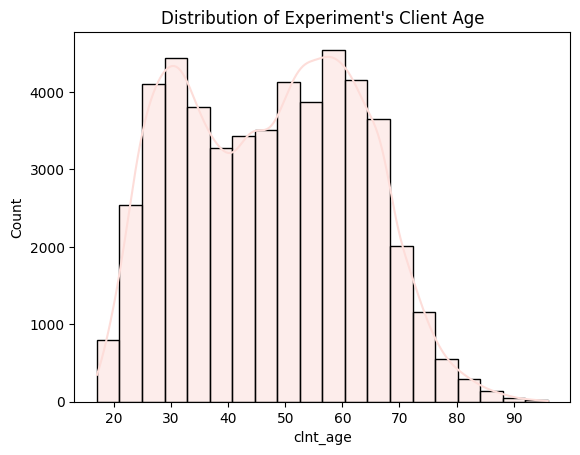

In [47]:
sns.set_palette("RdPu")
sns.histplot(final_rooster_process_counts_profile['clnt_age'], bins=20, kde=True)
plt.title("Distribution of Experiment's Client Age")
plt.show()

Visualizing client tenure, or years with the company. 

From Vanguard's inception to 2017, the max years a client can have with the company is 42 years. We filtered out the clients that were about that number.

In [147]:
max_value = 42
final_rooster_process_counts_profile['clnt_tenure_yr']
final_rooster_process_counts_profile['clnt_tenure_yr'] = np.where(final_rooster_process_counts_profile['clnt_tenure_yr'] > max_value, np.nan, final_rooster_process_counts_profile['clnt_tenure_yr'])

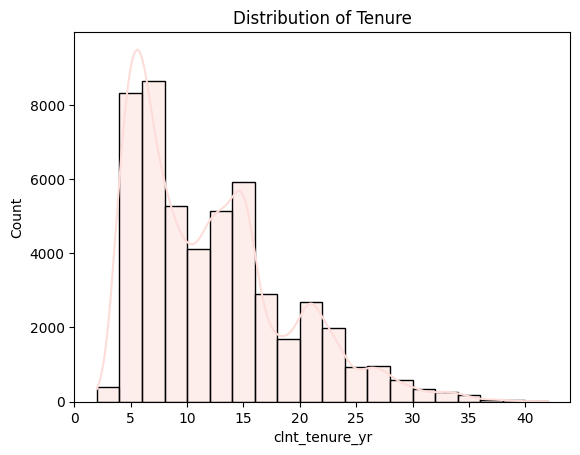

In [148]:
sns.set_palette("RdPu")
sns.histplot(final_rooster_process_counts_profile['clnt_tenure_yr'], bins=20, kde=True)
plt.title('Distribution of Tenure')
plt.show()

Visualizing the distribution of the client's age across both groups using bins.

In [49]:
final_rooster_process_counts_profile['age_group'] = pd.cut(final_rooster_process_counts_profile['clnt_age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70-80'])

Text(0.5, 1.0, 'Distribution of Clients by Age Group')

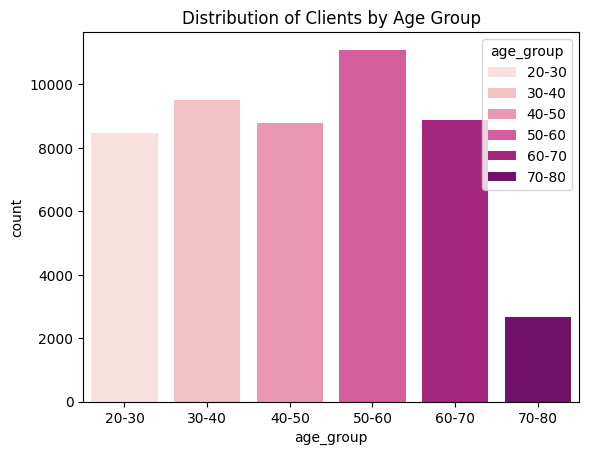

In [52]:
sns.set_palette("RdPu")
sns.countplot(x='age_group', data=final_rooster_process_counts_profile, hue='age_group')
plt.title('Distribution of Clients by Age Group')

# Exploring data types & missing values

# This code was used at the beginning of the project when dataframes weren't clean. Since then, the dataframes have changed, but we still leave this part for you to see what steps we took to clean the datasets.

In [19]:
client_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         70609 non-null  int64  
 1   clnt_tenure_yr    70595 non-null  float64
 2   clnt_tenure_mnth  70595 non-null  float64
 3   clnt_age          70594 non-null  float64
 4   gendr             70595 non-null  object 
 5   num_accts         70595 non-null  float64
 6   bal               70595 non-null  float64
 7   calls_6_mnth      70595 non-null  float64
 8   logons_6_mnth     70595 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.8+ MB


In [20]:
client_profiles.columns

Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'],
      dtype='object')

In [21]:
digital_footprints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160786 entries, 0 to 160785
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   client_id       160786 non-null  int64         
 1   visitor_id_x    160786 non-null  object        
 2   visit_id_x      160786 non-null  object        
 3   process_step_x  160786 non-null  object        
 4   date_time_x     160786 non-null  datetime64[ns]
 5   visitor_id_y    160786 non-null  object        
 6   visit_id_y      160786 non-null  object        
 7   process_step_y  160786 non-null  object        
 8   date_time_y     160786 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 11.0+ MB


In [71]:
digital_footprints.columns

Index(['client_id', 'visitor_id_x', 'visit_id_x', 'process_step_x',
       'date_time_x', 'visitor_id_y', 'visit_id_y', 'process_step_y',
       'date_time_y'],
      dtype='object')

In [72]:
digital_footprints['date_time_x']

0         2017-04-05 16:06:35
1         2017-04-05 16:06:35
2         2017-04-05 16:06:35
3         2017-04-05 16:06:35
4         2017-04-05 16:06:35
                 ...         
160781    2017-03-31 15:15:46
160782    2017-03-31 15:14:53
160783    2017-03-31 15:12:08
160784    2017-03-31 15:11:37
160785    2017-03-31 15:10:47
Name: date_time_x, Length: 160786, dtype: object

In [10]:
experiment_roster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  70609 non-null  int64 
 1   Variation  50500 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [53]:
experiment_roster.columns

Index(['client_id', 'Variation'], dtype='object')

In [87]:
client_footprints

client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age gendr  \
0         2892152             4.0              58.0      36.0     U   
1         2892152             4.0              58.0      36.0     U   
2         2892152             4.0              58.0      36.0     U   
3         2892152             4.0              58.0      36.0     U   
4         2892152             4.0              58.0      36.0     U   
...           ...             ...               ...       ...   ...   
155568    7807844             5.0              70.0      37.0     U   
155569    7807844             5.0              70.0      37.0     U   
155570    7807844             5.0              70.0      37.0     U   
155571    7807844             5.0              70.0      37.0     U   
155572    7807844             5.0              70.0      37.0     U   

        num_accts        bal  calls_6_mnth  logons_6_mnth  \
0             2.0   46815.48           5.0            8.0   
1             2.0   46815.48           5.0            8.0   
2             2.0   46815.48           5.0            8.0   
3             2.0   46815.48           5.0            8.0   
4             2.0   46815.48           5.0            8.0   
...           ...        ...           ...            ...   
155568        2.0  493497.05           2.0            2.0   
155569        2.0  493497.05           2.0            2.0   
155570        2.0  493497.05           2.0            2.0   
155571        2.0  493497.05           2.0            2.0   
155572        2.0  493497.05           2.0            2.0   

                 visitor_id_x                    visit_id_x process_step_x  \
0       475009955_99741870924   953097438_9608092216_244580          start   
1       475009955_99741870924   953097438_9608092216_244580          start   
2       475009955_99741870924   953097438_9608092216_244580          start   
3       475009955_99741870924   953097438_9608092216_244580          start   
4       475009955_99741870924   953097438_9608092216_244580          start   
...                       ...                           ...            ...   
155568   22703806_12091389151  582197818_99560699743_991536         step_1   
155569   22703806_12091389151  582197818_99560699743_991536          start   
155570   22703806_12091389151  582197818_99560699743_991536          start   
155571   22703806_12091389151  582197818_99560699743_991536          start   
155572   22703806_12091389151  582197818_99560699743_991536          start   

                date_time_x           visitor_id_y  \
0       2017-04-05 22:33:57  475009955_99741870924   
1       2017-04-05 22:33:57  475009955_99741870924   
2       2017-04-05 22:33:57  475009955_99741870924   
3       2017-04-05 22:33:57  475009955_99741870924   
4       2017-04-05 22:33:57  475009955_99741870924   
...                     ...                    ...   
155568  2017-04-19 11:14:13  355191087_38612428309   
155569  2017-04-19 11:14:08  355191087_38612428309   
155570  2017-04-19 11:14:08  355191087_38612428309   
155571  2017-04-19 11:14:08  355191087_38612428309   
155572  2017-04-19 11:14:08  355191087_38612428309   

                          visit_id_y process_step_y          date_time_y  
0       444789517_93530657187_644985        confirm  2017-05-06 22:41:48  
1       444789517_93530657187_644985         step_3  2017-05-06 22:39:41  
2       444789517_93530657187_644985         step_2  2017-05-06 22:38:09  
3       444789517_93530657187_644985         step_1  2017-05-06 22:37:12  
4       444789517_93530657187_644985          start  2017-05-06 22:34:49  
...                              ...            ...                  ...  
155568    218671552_6538580332_69944          start  2017-06-18 20:12:35  
155569    218671552_6538580332_69944         step_3  2017-06-18 20:15:01  
155570    218671552_6538580332_69944         step_2  2017-06-18 20:13:39  
155571    218671552_6538580332_69944         step_1  2017-06-18 20:12:40  
155572    2

In [88]:
grouped_data

client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age gendr  \
0         2892152             4.0              58.0      36.0     U   
1         2892152             4.0              58.0      36.0     U   
2         2892152             4.0              58.0      36.0     U   
3         2892152             4.0              58.0      36.0     U   
4         2892152             4.0              58.0      36.0     U   
...           ...             ...               ...       ...   ...   
155568    7807844             5.0              70.0      37.0     U   
155569    7807844             5.0              70.0      37.0     U   
155570    7807844             5.0              70.0      37.0     U   
155571    7807844             5.0              70.0      37.0     U   
155572    7807844             5.0              70.0      37.0     U   

        num_accts        bal  calls_6_mnth  logons_6_mnth  \
0             2.0   46815.48           5.0            8.0   
1             2.0   46815.48           5.0            8.0   
2             2.0   46815.48           5.0            8.0   
3             2.0   46815.48           5.0            8.0   
4             2.0   46815.48           5.0            8.0   
...           ...        ...           ...            ...   
155568        2.0  493497.05           2.0            2.0   
155569        2.0  493497.05           2.0            2.0   
155570        2.0  493497.05           2.0            2.0   
155571        2.0  493497.05           2.0            2.0   
155572        2.0  493497.05           2.0            2.0   

                 visitor_id_x                    visit_id_x process_step_x  \
0       475009955_99741870924   953097438_9608092216_244580          start   
1       475009955_99741870924   953097438_9608092216_244580          start   
2       475009955_99741870924   953097438_9608092216_244580          start   
3       475009955_99741870924   953097438_9608092216_244580          start   
4       475009955_99741870924   953097438_9608092216_244580          start   
...                       ...                           ...            ...   
155568   22703806_12091389151  582197818_99560699743_991536         step_1   
155569   22703806_12091389151  582197818_99560699743_991536          start   
155570   22703806_12091389151  582197818_99560699743_991536          start   
155571   22703806_12091389151  582197818_99560699743_991536          start   
155572   22703806_12091389151  582197818_99560699743_991536          start   

                date_time_x           visitor_id_y  \
0       2017-04-05 22:33:57  475009955_99741870924   
1       2017-04-05 22:33:57  475009955_99741870924   
2       2017-04-05 22:33:57  475009955_99741870924   
3       2017-04-05 22:33:57  475009955_99741870924   
4       2017-04-05 22:33:57  475009955_99741870924   
...                     ...                    ...   
155568  2017-04-19 11:14:13  355191087_38612428309   
155569  2017-04-19 11:14:08  355191087_38612428309   
155570  2017-04-19 11:14:08  355191087_38612428309   
155571  2017-04-19 11:14:08  355191087_38612428309   
155572  2017-04-19 11:14:08  355191087_38612428309   

                          visit_id_y process_step_y          date_time_y  \
0       444789517_93530657187_644985        confirm  2017-05-06 22:41:48   
1       444789517_93530657187_644985         step_3  2017-05-06 22:39:41   
2       444789517_93530657187_644985         step_2  2017-05-06 22:38:09   
3       444789517_93530657187_644985         step_1  2017-05-06 22:37:12   
4       444789517_93530657187_644985          start  2017-05-06 22:34:49   
...                              ...            ...                  ...   
155568    218671552_6538580332_69944          start  2017-06-18 20:12:35   
155569    218671552_6538580332_69944         step_3  2017-06-18 20:15:01   
155570    218671552_6538580332_69944         step_2  2017-06-18 20:13:39   
155571    218671552_6538580332_69944         step_1  2017-06-18 20:12:40   


Observation - there are null values on test variation

In [39]:
# Spotting duplicates
grouped_data.duplicated().sum()

8887

In [40]:
grouped_data.describe()

client_id  clnt_tenure_yr  clnt_tenure_mnth       clnt_age  \
count  1.555730e+05   155543.000000     155543.000000  155543.000000   
mean   5.041359e+06       13.585253        169.027973      55.039880   
min    1.643000e+03        2.000000         34.000000      15.000000   
25%    2.564246e+06        7.000000         86.000000      45.000000   
50%    5.128835e+06       12.000000        155.000000      57.000000   
75%    7.456903e+06       19.000000        238.000000      66.000000   
max    9.999729e+06       54.000000        655.000000      93.000000   
std    2.854246e+06        7.684740         92.005690      15.947932   

           num_accts           bal   calls_6_mnth  logons_6_mnth  \
count  155543.000000  1.555430e+05  155543.000000  155543.000000   
mean        2.336421  2.463716e+05       4.657837       6.829166   
min         2.000000  1.379134e+04       0.000000       1.000000   
25%         2.000000  4.923532e+04       3.000000       5.000000   
50%         2.000000  1.004957e+05       5.000000       7.000000   
75%         3.000000  2.255843e+05       6.000000       9.000000   
max         6.000000  1.632004e+07       7.000000       9.000000   
std         0.612464  6.748682e+05       2.002529       2.103210   

                         date_time_x                    date_time_y  
count                         155573                         155573  
mean   2017-04-11 04:51:05.182429184  2017-05-22 01:35:02.175904512  
min              2017-03-15 00:03:03            2017-05-01 00:00:28  
25%              2017-04-04 21:19:16            2017-05-08 19:20:10  
50%              2017-04-10 10:43:27            2017-05-19 17:36:04  
75%              2017-04-18 15:34:53            2017-06-03 19:23:37  
max              2017-04-30 23:59:16            2017-06-20 23:57:06  
std                              NaN                            NaN

In [41]:
# Categorical
grouped_data.select_dtypes("object").columns

Index(['gendr', 'visitor_id_x', 'visit_id_x', 'process_step_x', 'visitor_id_y',
       'visit_id_y', 'process_step_y', 'Variation'],
      dtype='object')

In [42]:
grouped_data.select_dtypes("object").nunique().sort_values(ascending=False)

visit_id_x        7884
visit_id_y        7101
visitor_id_x      6066
visitor_id_y      5810
process_step_x       5
process_step_y       5
gendr                4
Variation            2
dtype: int64

In [43]:
# Numerical to do 
# Client_id is usually CATEGORICAL
grouped_data.select_dtypes("number").columns

Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'],
      dtype='object')

In [44]:
grouped_data.select_dtypes("number").nunique().sort_values(ascending=False)

client_id           5289
bal                 5288
clnt_tenure_mnth     402
clnt_age             152
clnt_tenure_yr        44
logons_6_mnth          9
calls_6_mnth           8
num_accts              5
dtype: int64

In [48]:
grouped_data['Variation'].describe()

count     111079
unique         2
top         Test
freq       62904
Name: Variation, dtype: object

In [49]:
# Seeing the A/B groups
grouped_data['Variation'].value_counts()

Variation
Test       62904
Control    48175
Name: count, dtype: int64

In [ ]:
# Questions:
1. Who are the primary clients using this online process?
 
    # gendr, bal

2. Are the primary clients younger or older, new or long-standing?

    # clnt_tenure_yr, clnt_tenure_mnth, clnt_age, 

# Exploring client data

In [52]:
client_profiles.value_counts()

client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age  gendr  num_accts  bal        calls_6_mnth  logons_6_mnth
169        21.0            262.0             47.5      M      2.0        501570.72  4.0           4.0              1
6663225    16.0            193.0             40.5      F      2.0        47445.45   2.0           5.0              1
6664483    22.0            271.0             46.5      M      4.0        699384.16  6.0           9.0              1
6664376    17.0            207.0             64.0      M      2.0        311829.13  7.0           7.0              1
6664052    32.0            394.0             71.0      M      2.0        79642.36   0.0           4.0              1
                                                                                                                  ..
3360049    16.0            203.0             35.5      F      2.0        53572.85   0.0           3.0              1
3360254    6.0             73.0              19.0      U      2.0    

# Visualize Data

Numerical Measures: These can include coefficients, frequency counts, and other statistical metrics.

Visual Representations: Examples are histograms, scatter plots, pie charts, and more.

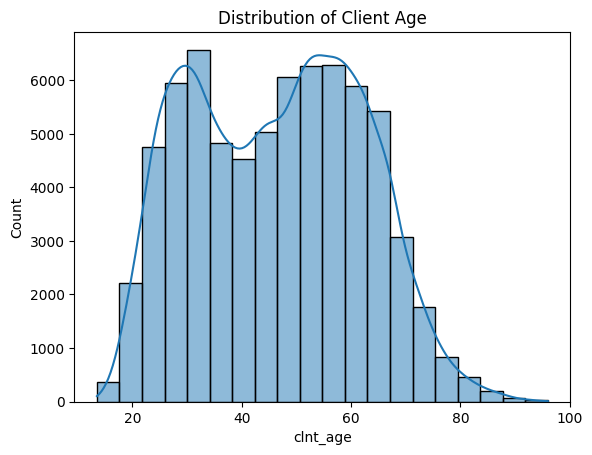

In [71]:
sns.histplot(client_profiles['clnt_age'], bins=20, kde=True)
plt.title('Distribution of Client Age')
plt.show()

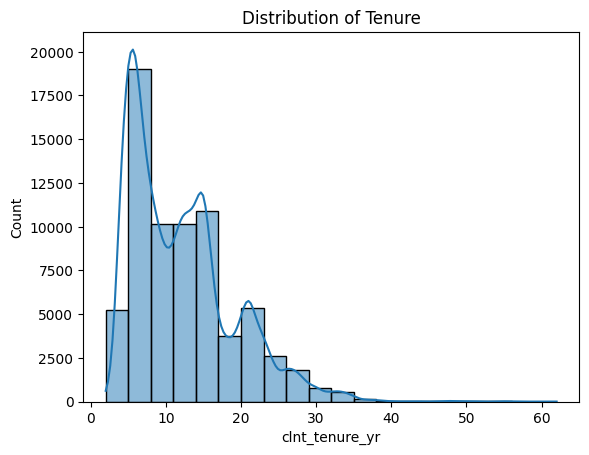

In [72]:
sns.histplot(client_profiles['clnt_tenure_yr'], bins=20, kde=True)
plt.title('Distribution of Tenure')
plt.show()

In [76]:
# Segmenting Clients
client_profiles['age_group'] = pd.cut(client_profiles['clnt_age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70-80'])

In [77]:
client_profiles['age_group']

0        60-70
1        50-60
2        30-40
3        40-50
4        30-40
         ...  
70604    30-40
70605    30-40
70606    60-70
70607    60-70
70608    50-60
Name: age_group, Length: 70609, dtype: category
Categories (6, object): ['20-30' < '30-40' < '40-50' < '50-60' < '60-70' < '70-80']

Text(0.5, 1.0, 'Distribution of Clients by Age Group')

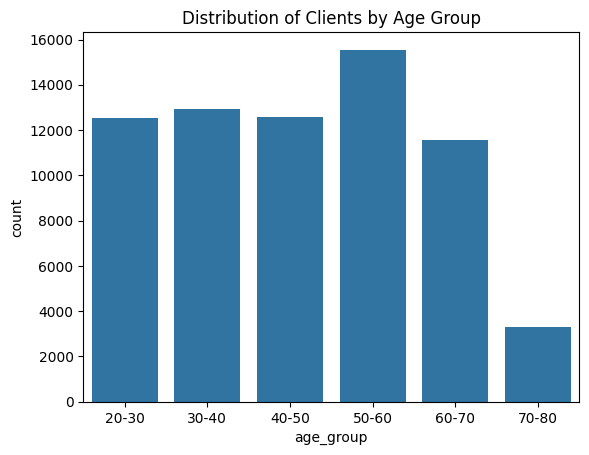

In [78]:
sns.countplot(x='age_group', data=client_profiles)
plt.title('Distribution of Clients by Age Group')

In [79]:
# Exploring Client Tenure

Text(0.5, 1.0, 'Age vs. Tenure')

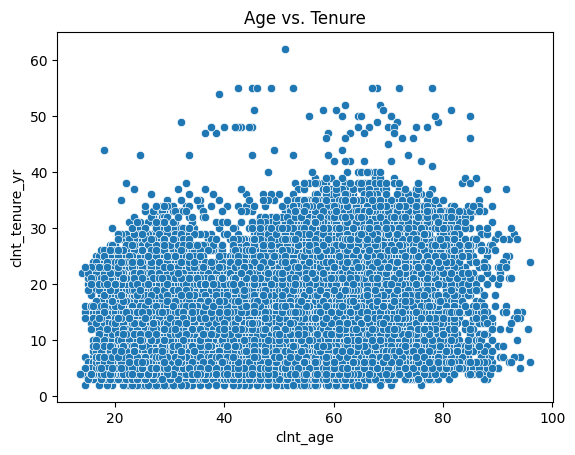

In [80]:
sns.scatterplot(x='clnt_age', y='clnt_tenure_yr', data=client_profiles)
plt.title('Age vs. Tenure')

In [81]:
# Comparing the groups

Text(0.5, 1.0, 'Age Distribution by A/B Test')

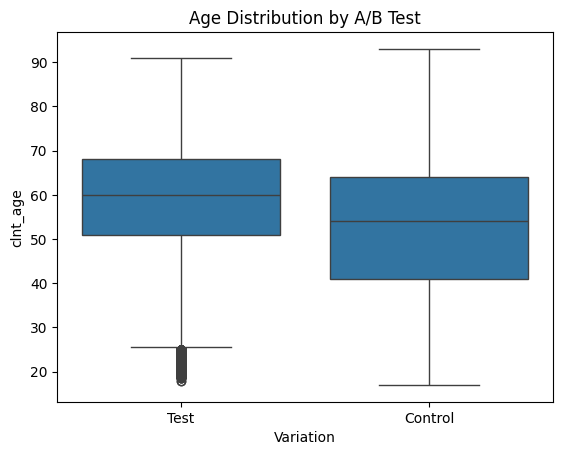

In [82]:
sns.boxplot(x='Variation', y='clnt_age', data=grouped_data)
plt.title('Age Distribution by A/B Test')

# Performing Client Behavior Analysis

In [83]:
# Key Metrics

Text(0.5, 1.0, 'Number of Logons in the Last 6 Months by Variation')

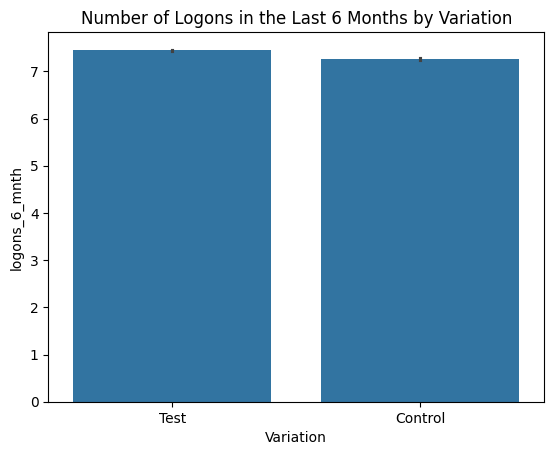

In [84]:
sns.barplot(x='Variation', y='logons_6_mnth', data=grouped_data)
plt.title('Number of Logons in the Last 6 Months by Variation')

Text(0.5, 1.0, 'Number of Calls in the Last 6 Months by Variation')

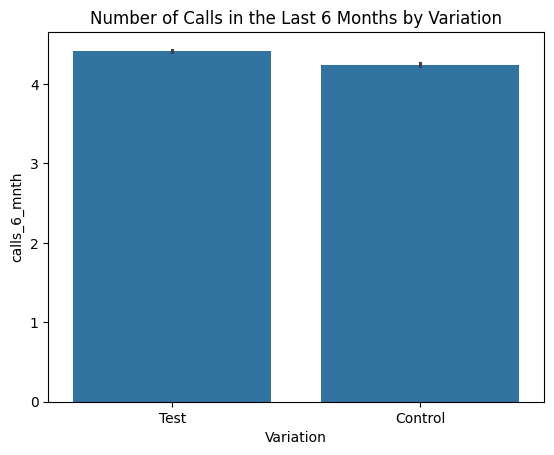

In [85]:
sns.barplot(x='Variation', y='calls_6_mnth', data=grouped_data)
plt.title('Number of Calls in the Last 6 Months by Variation')

In [ ]:
# Data for login information for each group variation during A/B testing

In [ ]:
####### This code is for interactive visualization on dashboard

In [ ]:
ab_test_data = grouped_data[(grouped_data['date_time_x'] >= '2017-03-15') & (grouped_data['date_time_x'] <= '2017-06-20')]
ab_test_data

In [63]:
grouped_data['date_time_x'].min()

Timestamp('2017-03-15 00:03:03')

In [ ]:
test_data = ab_test_data[ab_test_data['Variation'] == 'Test']
test_data

In [ ]:
control_data = ab_test_data[ab_test_data['Variation'] == 'Control']
control_data

In [90]:
conversion_rates = grouped_data.groupby('Variation')['process_step_x'].value_counts(normalize=True).unstack()
desired_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
conversion_rates = conversion_rates[desired_order]
conversion_rates

process_step_x     start    step_1    step_2    step_3   confirm
Variation                                                       
Control         0.547151  0.201349  0.143788  0.090690  0.017021
Test            0.460464  0.240446  0.160642  0.091346  0.047104

Text(0.5, 1.0, 'Completion Rates by Process Step and Test Group')

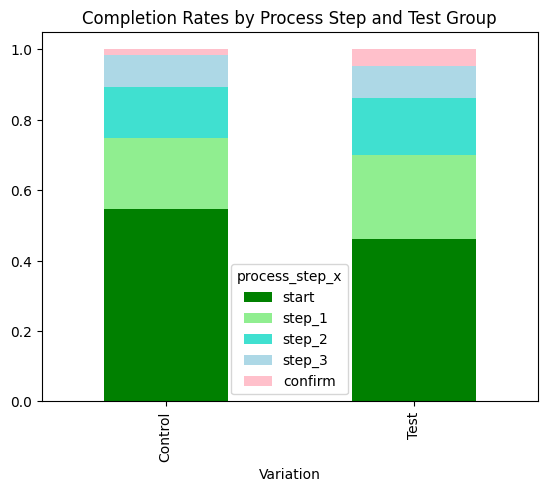

In [91]:
custom_palette = {'start': 'green', 'step_1': 'lightgreen', 'step_2': 'turquoise', 'step_3': 'lightblue', 'confirm': 'pink'}
conversion_rates.plot(kind='bar', stacked=True, color=[custom_palette[col] for col in conversion_rates.columns])
plt.title('Conversion Rates by Process Step and Variation')
plt.title('Completion Rates by Process Step and Test Group')

In [92]:
grouped_data['age_group'] = pd.cut(grouped_data['clnt_age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70-80'])
grouped_data['age_group']

0         30-40
1         30-40
2         30-40
3         30-40
4         30-40
          ...  
155568    30-40
155569    30-40
155570    30-40
155571    30-40
155572    30-40
Name: age_group, Length: 155573, dtype: category
Categories (6, object): ['20-30' < '30-40' < '40-50' < '50-60' < '60-70' < '70-80']

Text(0.5, 1.0, 'Number of Logons by Age Group and Test Group')

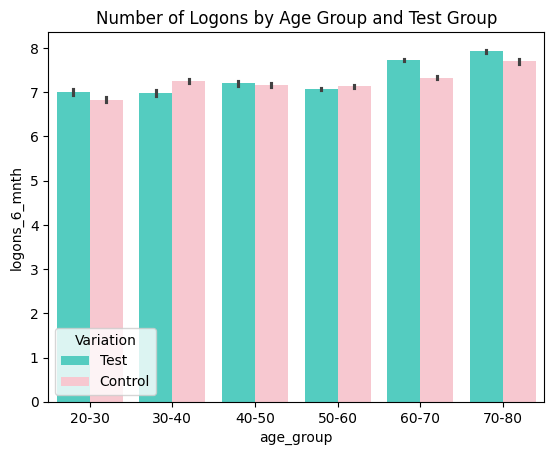

In [93]:
custom_palette = {'Test': 'turquoise', 'Control': 'pink'}

sns.barplot(x='age_group', y='logons_6_mnth', hue='Variation', data=grouped_data, palette=custom_palette)
plt.title('Number of Logons by Age Group and Test Group')

Text(0.5, 1.0, 'Distribution of Clients by Age Group')

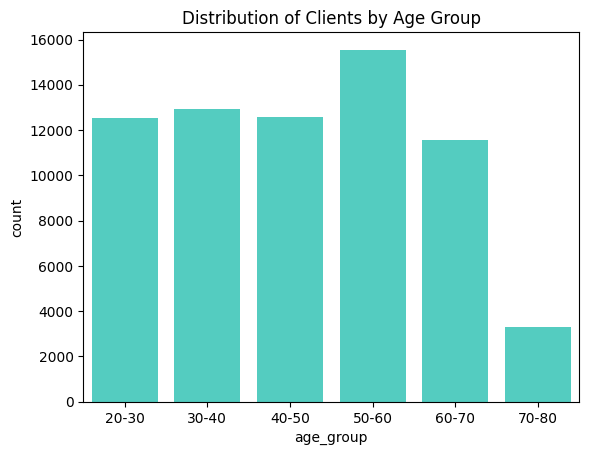

In [94]:
sns.countplot(x='age_group', data=client_profiles, color='turquoise')
plt.title('Distribution of Clients by Age Group')